## Initial Imports and image loading

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Read the image
# img = cv2.imread('chess images/IMG_20211010_151046.jpg')
img = cv2.imread('testImg/testImg.png')

In [4]:
print('Original Dimensions: ', img.shape)

Original Dimensions:  (481, 696, 3)


In [5]:
# cv2.imshow('original', img)
# cv2.waitKey(0)

In [6]:
sml_img = img

## Set up image

In [7]:
# # Resize image
# scale_percent = 10
# width = int(img.shape[1] * scale_percent / 100)
# height = int(img.shape[0] * scale_percent / 100)
# dim = (width, height)

# sml_img = cv2.resize(img, dim)
# print('Resized Dimensions: ', sml_img.shape)

In [8]:
# cv2.imshow('Resized', sml_img)
# cv2.waitKey(0)

In [9]:
# Convert to grayscale
img_gray = cv2.cvtColor(sml_img, cv2.COLOR_BGR2GRAY)

In [10]:
# Blur image for better edge detection
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)

## Prewitt filter

In [11]:
# prewitt
kernelx = np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
kernely = np.array([[-1,0,1], [-1,0,1], [-1,0,1]])
img_prewittx = cv2.filter2D(img_blur, -1, kernelx)
img_prewitty = cv2.filter2D(img_blur, -1, kernely)
# img_prewitt = img_prewittx + img_prewitty

# img_prewitt = np.sqrt((img_prewittx * img_prewittx) + (img_prewitty * img_prewitty))
img_prewitt = np.hypot(img_prewittx, img_prewitty)
img_prewitt = img_prewitt / img_prewitt.max() * 255
img_prewitt = img_prewitt.astype('uint8')

theta = np.arctan2(img_prewitty, img_prewittx).astype('uint8')

In [12]:
# cv2.imshow("Prewitt X", img_prewittx)
# cv2.imshow("Prewitt Y", img_prewitty)
# cv2.imshow("Prewitt", img_prewitt)

# cv2.waitKey(0)

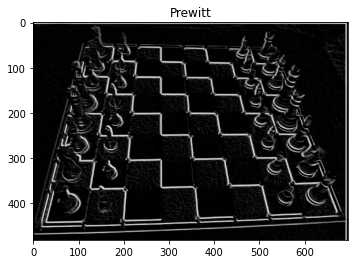

In [13]:
plt.imshow(img_prewitt, cmap=plt.cm.Greys_r)
plt.title("Prewitt")
plt.show()

In [14]:
# from scipy import ndimage

# Kx = np.array([[1,1,1], [0,0,0], [-1,-1,-1]])
# Ky = np.array([[-1,0,1], [-1,0,1], [-1,0,1]])

# Ix = ndimage.filters.convolve(img_blur, Kx)
# Iy = ndimage.filters.convolve(img_blur, Ky)


# # prewitt1 = np.sqrt((Ix * Ix) + (Iy * Iy))
# prewitt1 = np.hypot(Ix, Iy)

# prewitt1 = prewitt1 / prewitt1.max() * 255
# prewitt1 = prewitt1.astype('uint8')


In [15]:
# # cv2.imshow("Prewitt X", Ix)
# # cv2.imshow("Prewitt Y", Iy)
# cv2.imshow("Prewitt", prewitt1)

# cv2.waitKey(0)

## Canny Algorithm
- non-maximal suppression applied to reduce weak edges 
- hysteresis thresholding omitted to maximize the number of line pixels. 

In [16]:
# img_canny = cv2.Canny(img_prewitt, 0, 0)

In [17]:
# cv2.imshow("Canny", img_canny)
# cv2.waitKey(0)

In [18]:
def non_max_suppression(img, D):
    width, height = img.shape
    returnImg = np.zeros((width,height), dtype=np.uint8)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,width-1):
        for j in range(1,height-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    returnImg[i,j] = img[i,j]
                else:
                    returnImg[i,j] = 0

            except IndexError as e:
                pass
    
    return returnImg    

In [19]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.uint8)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

In [20]:
def myCanny(img, theta):
    res = non_max_suppression(img, theta)
    res, weak, strong = threshold(res)
    return res

In [21]:
img_canny = myCanny(img_prewitt, theta)

# img_canny = non_max_suppression(img_prewitt, theta)
# print(img_canny)

# cv2.imshow("Canny", img_canny)
# cv2.waitKey(0)

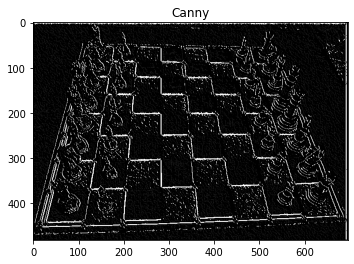

In [22]:
plt.imshow(img_canny, cmap=plt.cm.Greys_r)
plt.title("Canny")
plt.show()

## Radon transform
- compute the Radon transform over 360° (Note that the matrix actually repeats after 180° but flipped vertically). 

In [23]:
from skimage.transform import radon

# theta1 = np.linspace(0., 180., max(img_canny.shape), endpoint=False)
theta1 = np.linspace(0., 360., max(img_canny.shape),endpoint=False)
sinogram = radon(img_canny, theta=theta1)

C:\Users\samra\AppData\Local\Programs\Python\Python39\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


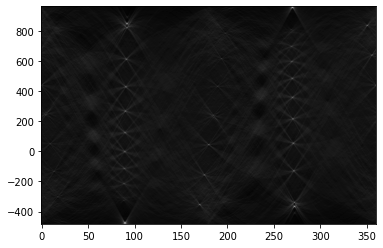

In [24]:
import matplotlib.pyplot as plt

dx, dy = 0.5 * 360.0 / max(img_canny.shape), sinogram.shape[0]
plt.imshow(sinogram, cmap=plt.cm.Greys_r,extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')
#plt.imshow(sinogram, 'gray',extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')

plt.show()


In [25]:
sinogram

array([[51.50980392, 26.0321436 , 23.17924493, ..., 31.2397633 ,
        27.26477421, 30.34446709],
       [46.17647059, 42.15658228, 29.62164716, ..., 33.01180289,
        32.887257  , 32.37459254],
       [24.78431373, 36.62164599, 35.79728612, ..., 31.3809966 ,
        40.48544856, 40.52693726],
       ...,
       [33.88235294, 34.51758812, 24.09697656, ..., 17.09164914,
        21.46387066, 26.96772035],
       [37.80392157, 30.99232232, 17.68335035, ..., 14.71218884,
        20.94998651, 30.27928411],
       [28.68627451, 14.31427444, 15.00946068, ..., 17.42716035,
        20.52633053, 21.38998136]])

## Determine the general direction of the lines in the image

apply simple threshold based on the standard deviation


In [26]:
stdDev = np.std(sinogram)

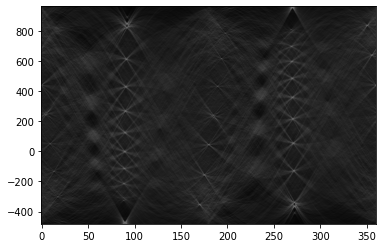

In [27]:
ret,bestLinePoints1 = cv2.threshold(sinogram, 100 + stdDev,255,cv2.THRESH_TRUNC)
plt.imshow(bestLinePoints1,'gray',vmin=0,vmax=255, extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')

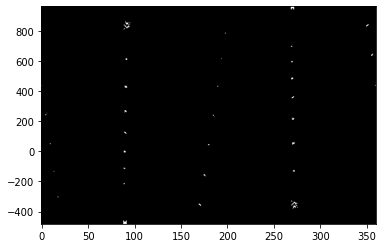

In [28]:
ret,bestLinePoints2 = cv2.threshold(bestLinePoints1, 80 + stdDev,255,cv2.THRESH_BINARY)
plt.imshow(bestLinePoints2,'gray',vmin=0,vmax=255, extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')

In [29]:
points = []

for i in range(len(bestLinePoints2)):
    for j in range(len(bestLinePoints2[0])):
        if bestLinePoints2[i][j] != 0:
            points.append([j,i])

print(len(points))

470


In [30]:
points2 = sorted(points, key=lambda x: x[0])

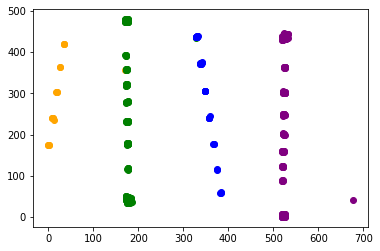

In [31]:
prevX = 0
count = 0

colorArr = ['red', 'orange', 'green', 'blue', 'purple', 'yellow', 'black', 'pink']
lineArr = []
xArr = np.array([])
yArr = np.array([])

for (x, y) in points2:
    xArr = np.append(xArr, x)
    yArr = np.append(yArr, y)
    
    # xArr.append(x)
    # yArr.append(y)
    if x > (prevX+90):
        m, b = np.polyfit(xArr, yArr, 1)

        count+= 1        
        if count > 7:
            count = 0
        
        # plt.plot(xArr, m*xArr + b)
        plt.plot(xArr, yArr, 'o', c=colorArr[count])

        lineArr.append([xArr, yArr])
        xArr = np.array([])
        yArr = np.array([])

    prevX = x
    

plt.show()

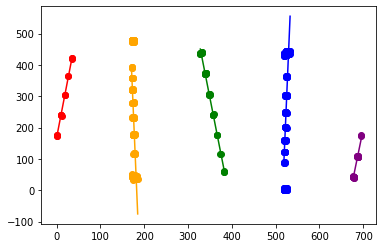

In [32]:
prevX = 0
count = 0

colorArr = ['red', 'orange', 'green', 'blue', 'purple', 'yellow', 'black', 'pink']
lineArr = []
gradientsArr = []
xArr = np.array([])
yArr = np.array([])
(x,y) = points2[0]

counter = 0
while counter < len(points2):
	while x < (prevX+90):
		prevX = x

		xArr = np.append(xArr, x)
		yArr = np.append(yArr, y)
		
		counter += 1

		if counter > (len(points2)-1):
			break

		(x,y) = points2[counter]

	prevX = x
	# get gradient and y-intercept for line of best fit
	m, b = np.polyfit(xArr, yArr, 1)
	gradientsArr.append([m,b])

	# plot points and lines
	plt.plot(xArr, m*xArr + b, c=colorArr[count])
	plt.plot(xArr, yArr, 'o', c=colorArr[count])

	lineArr.append([xArr, yArr])
	xArr = np.array([])
	yArr = np.array([])

	count+= 1        
	if count > 7:
		count = 0

		

plt.show()

In [33]:
def drawLinesOntop(image, arrGradient, arrLines):
    m = 0
    b = 0
    xArr = []
    yArr = []

    plt.imshow(image, cmap=plt.cm.Greys_r, aspect='auto')
    # plt.imshow(bestLinePoints,'gray',vmin=0,vmax=255, aspect='auto')

    for i in range(len(arrGradient)):
        m,b = arrGradient[i]
        xArr, yArr = arrLines[i]
        plt.plot(xArr, m*xArr + b)


    plt.show()

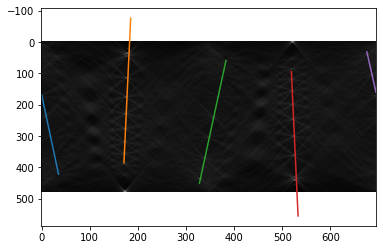

In [34]:

# m = 0
# b = 0
# xArr = []
# yArr = []

# plt.imshow(sinogram, cmap=plt.cm.Greys_r, aspect='auto')
# # plt.imshow(bestLinePoints,'gray',vmin=0,vmax=255, aspect='auto')

# for i in range(len(gradientsArr)):
# 	m,b = gradientsArr[i]
# 	xArr, yArr = lineArr[i]
# 	plt.plot(xArr, m*xArr + b)


# plt.show()
	
drawLinesOntop(sinogram, gradientsArr, lineArr)


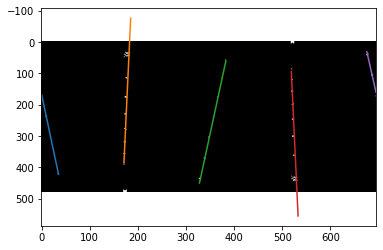

In [35]:
drawLinesOntop(bestLinePoints2, gradientsArr, lineArr)

## calculate second derivative along these cross-sections 

In [36]:
# sinogram
# gradientsArr
# lineArr

X_green = lineArr[2][0]
X_red = lineArr[3][0]

Y_green = (gradientsArr[2][0] * X_green) + gradientsArr[2][1]
Y_red = (gradientsArr[3][0] * X_red) + gradientsArr[3][1]

len(X_green)

43

In [37]:
def getSinoVals(X_arr, Y_arr, sinogram):
    sino_vals = []

    for i in range(len(X_arr)):
        locX = round(X_arr[i])
        locY = round(Y_arr[i])
        # print(locX, locY)

        sino_vals.append(sinogram[locX][locY])

    return sino_vals
    

In [38]:
green_sino_vals = getSinoVals(X_green, Y_green, sinogram)
# red_sino_vals = getSinoVals(X_red, Y_red, sinogram)

In [39]:

from scipy.ndimage import laplace 

second_derivative_abs = np.abs(laplace(sinogram))
print(second_derivative_abs)

[[30.81099366 38.74920034  7.20194731 ...  2.37015414 12.67716475
   1.04956742]
 [20.07871184 30.17442177 13.66484127 ... 13.46319539  1.58759019
   6.63488373]
 [53.95497932  9.1944646   5.80953305 ...  0.43868137 21.72123157
   7.35794696]
 ...
 [ 1.67445087 21.2506579   1.11723258 ...  6.89570216  0.06677484
   3.37921534]
 [19.85081494 19.65015479 11.86302044 ...  7.56969383  3.1817281
  21.5301641 ]
 [ 5.25435301 31.7452342   0.43779991 ...  1.25742101  1.81186336
   8.02565192]]


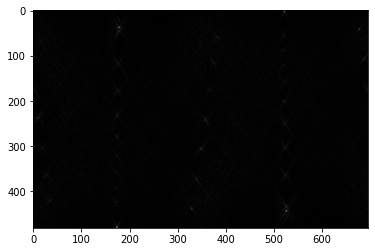

In [40]:
drawLinesOntop(second_derivative_abs, [], [])

### extract the second derivative from the cross section

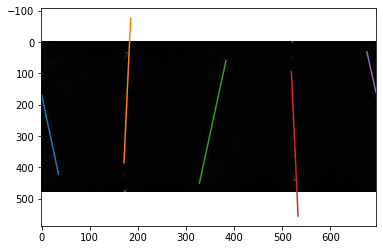

In [41]:
drawLinesOntop(second_derivative_abs, gradientsArr, lineArr)

In [42]:
X_green = lineArr[2][0]
X_red = lineArr[3][0]

Y_green = (gradientsArr[2][0] * X_green) + gradientsArr[2][1]
Y_red = (gradientsArr[3][0] * X_red) + gradientsArr[3][1]
X_green

array([328., 328., 328., 328., 329., 329., 330., 330., 330., 331., 331.,
       331., 332., 338., 338., 338., 339., 339., 339., 340., 340., 340.,
       341., 341., 347., 347., 348., 348., 349., 349., 357., 357., 358.,
       358., 360., 366., 367., 367., 374., 375., 382., 383., 383.])

In [43]:
def getValuesFromImage(X_arr, Y_arr, image):
    image_vals = np.array([])

    for i in range(len(X_arr)):
        locX = round(X_arr[i])
        locY = round(Y_arr[i])
        # print(locX, locY)

        image_vals = np.append(image_vals, image[locX][locY])

    return image_vals
    

In [44]:
greenSecDeriv = getValuesFromImage(X_green, Y_green, second_derivative_abs)
print(greenSecDeriv)

[11.44784033 11.44784033 11.44784033 11.44784033  5.14732718  5.14732718
 13.67395242 13.67395242 13.67395242  7.09548246  7.09548246  7.09548246
 15.08204427 15.80566242 15.80566242 15.80566242  8.65822948  8.65822948
  8.65822948  2.29582878  2.29582878  2.29582878 14.13270423 14.13270423
  7.83138487  7.83138487  6.39655065  6.39655065  1.18900266  1.18900266
  2.76146733  2.76146733  4.88209907  4.88209907  4.61869244 48.38129704
  2.04567262  2.04567262  6.78044419 18.27109276 10.72892045 15.79824001
 15.79824001]


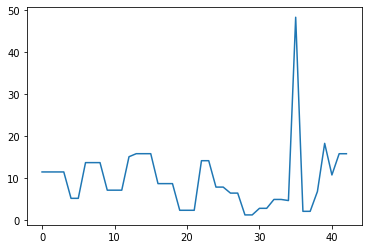

In [45]:
plt.plot(greenSecDeriv)

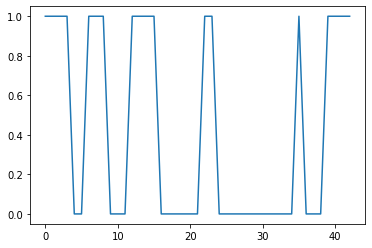

In [46]:
ret,greenPeaks = cv2.threshold(greenSecDeriv, 10,1,cv2.THRESH_BINARY)
plt.plot(greenPeaks)
# print(greenPeaks)
#plt.imshow(greenPeaks,'gray',vmin=0,vmax=255, extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')

In [47]:
greenPeaks

array([[1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [48]:
greenPeakCoords = []

for i in range(len(greenPeaks)):
	if greenPeaks[i] == 1:
		greenPeakCoords.append([X_green[i], Y_green[i]])

print(greenPeakCoords)

[[328.0, 450.4577669999403], [328.0, 450.4577669999403], [328.0, 450.4577669999403], [328.0, 450.4577669999403], [330.0, 436.2633842851178], [330.0, 436.2633842851178], [330.0, 436.2633842851178], [332.0, 422.0690015702953], [338.0, 379.4858534258283], [338.0, 379.4858534258283], [338.0, 379.4858534258283], [341.0, 358.19427935359454], [341.0, 358.19427935359454], [366.0, 180.7644954183147], [375.0, 116.88977320161393], [382.0, 67.2094336997352], [383.0, 60.11224234232395], [383.0, 60.11224234232395]]


## Reconstruction with Filtered Back Projection

In [49]:
from skimage.transform import iradon

theta2 = np.linspace(0., 360., max(img_canny.shape), endpoint=False)


reconstruction_fbp = iradon(sinogram, theta=theta2, filter_name='cosine')
# error = reconstruction_fbp - img_canny
# print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

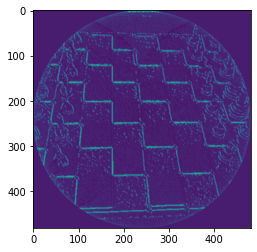

In [50]:
plt.imshow(reconstruction_fbp)
# plt.imshow(reconstruction_fbp, vmin=0,vmax=255, extent=(-dx, 360.0 + dx, -dy, sinogram.shape[0] + dy), aspect='auto')

## Reconstruction with Simultaneous Algebraic Technique

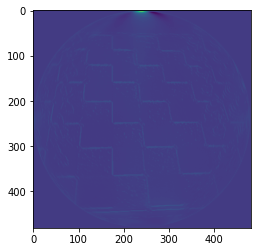

In [51]:
from skimage.transform import iradon_sart

reconstruction_sart = iradon_sart(sinogram, theta=theta1)
plt.imshow(reconstruction_sart)

In [58]:
cv2.imshow("Reconstruction", reconstruction_sart)
cv2.waitKey(5000)

13

# Misc For now











## Determine the best position to extract the data from the accumulator matrix

The best position is where the
standard deviation in the horizontal direction is at minimum (i.e. the data is not fragmented and the complete
trend can be seen)

In [113]:
stdDevX = np.std(sinogram, axis = 0)
stdDevY = np.std(sinogram, axis = 1)

In [120]:
print(np.where(stdDevX == min(stdDevX)))
print(sinogram[311])

(array([311], dtype=int64),)
[30.56862745 30.25505917 29.84505033 26.11145639 25.10248718 24.70520511
 27.91480646 34.33677193 41.70062614 44.91271367 47.0339395  47.26018221
 36.76002781 27.20709604 20.11370485 18.68585941 26.16194604 31.18336293
 35.20168011 30.43940607 30.89334065 29.13990069 24.08603047 37.35943858
 48.95408428 26.97577189 32.8564349  36.04854815 45.35987733 38.19782879
 32.27834507 31.76823309 30.52890285 34.26347921 26.54081209 27.5869569
 27.58487373 31.45169537 42.03195531 45.68481068 37.65485243 30.32825672
 36.33962456 32.33768254 31.15469028 32.65199977 29.66836729 29.06242604
 33.34019628 32.03502003 33.08167766 29.66886634 28.32298725 36.25211215
 34.61147554 33.50949299 34.78622849 32.15302282 30.33931956 29.98711094
 27.07586253 27.65482048 30.30029564 28.86846518 24.65996389 25.38381946
 24.83582166 38.60666984 37.36189475 30.42921794 33.96950152 36.86131407
 37.03960053 34.24959194 33.16250665 36.49986502 39.12896541 32.14356531
 26.76315123 22.5880325

In [140]:
min_x = []
min_std_Y = np.where(stdDevY == min(stdDevY))

for x in range(len(sinogram)):
    min_x.append([x, float(sinogram[x][min_std_Y])])

using the estimated points from the previous step, a best line fit can
be used to refine the result